In [1]:
import pandas as pd
import numpy as np
import src.utils as utils
from os import cpu_count
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

In [2]:
data = utils.load_data()
X = data.drop('increase_stock', axis=1)
Y = data['increase_stock']

In [3]:
bs_results = []
param_grid = {
    'model__learning_rate': [0.11, .13, .14],
    # 'n_estimators': [50, 100, 150], # USE THIS AS RESOURCE
    'model__max_depth': [2, 5, 7, 9, 12],
    'model__subsample': [1],
    'model__colsample_bytree': [.9, 1],
    'model__gamma': [0],
    'model__min_child_weight': [2, 3, 4],
    'model__reg_lambda': [0, 0.1, 0.15]
}
for i in range(100):
    print(f'{i + 1}/100')
    kf = KFold(n_splits=150, shuffle=False)  #150 so that we have 10 samples tested on each fold
    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=1 / 16,  #save 100 holdout
                                                        random_state=i + 1)
    model = utils.initialize_model_pipeline(XGBClassifier())
    search = HalvingGridSearchCV(model, param_grid=param_grid,
                                 cv=kf, scoring='accuracy',
                                 n_jobs=cpu_count() - 2,
                                 resource='model__n_estimators',
                                 max_resources=500)
    search.fit(x_train, y_train)
    y_hat = search.best_estimator_.predict(x_test)
    bs_results.append({
        'accuracy': accuracy_score(y_test, y_hat),
        'optimistic_accuracy': search.best_score_,
        'f1-score': f1_score(y_test, y_hat),
        'f1-score_macro': f1_score(y_test, y_hat, average='macro'),
        'f1-score_weighted': f1_score(y_test, y_hat, average='weighted'),
        'precision': precision_score(y_test, y_hat),
        'precision_macro': precision_score(y_test, y_hat, average='macro'),
        'precision_weighted': precision_score(y_test, y_hat, average='weighted'),
        'recall': recall_score(y_test, y_hat),
        'recall_macro': recall_score(y_test, y_hat, average='macro'),
        'recall_weighted': recall_score(y_test, y_hat, average='weighted'),
        'class_report': classification_report(y_test, y_hat) 
    })

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [5]:
results_df = pd.DataFrame(bs_results)
results_df.to_pickle('../data/insatiable.pkl')

In [6]:
print(f'mew out of sample accuracy - mew optimistic accuracy = {np.mean(results_df["accuracy"] - results_df["optimistic_accuracy"])}')
results_df[['accuracy','optimistic_accuracy']].mean()

mew out of sample accuracy - mew optimistic accuracy = -0.0017866666666667486


accuracy               0.882900
optimistic_accuracy    0.884687
dtype: float64

In [7]:
quantile_5 = np.percentile(results_df['accuracy'], 5, method="linear")
quantile_95 = np.percentile(results_df['accuracy'], 95, method="linear")
print(f'Mean accuracy: {results_df["accuracy"].mean()}')
print(f'~95% CI on out of sample accuracy [{quantile_5}, {quantile_95}]')

Mean accuracy: 0.8828999999999999
~95% CI on out of sample accuracy [0.83, 0.9305]


Text(0.5, 0, 'Accuracy distribution')

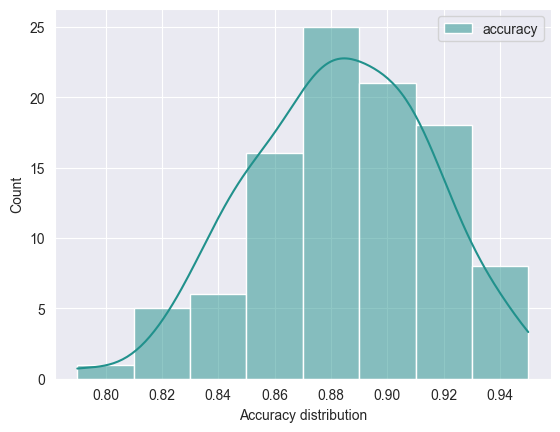

In [8]:
from seaborn import histplot
import matplotlib.pyplot as plt
histplot(data=results_df[['accuracy']], kde=True, palette='viridis')
plt.xlabel('Accuracy distribution')

Text(0.5, 0, 'Accuracy distribution')

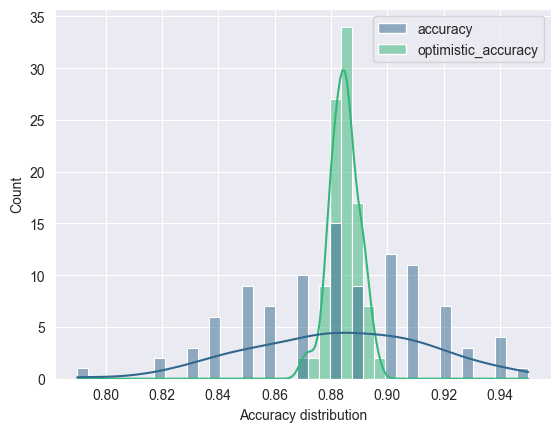

In [9]:
histplot(data=results_df[['accuracy', 'optimistic_accuracy']], kde=True, palette='viridis')
plt.xlabel('Accuracy distribution')